# 1. Introduction  
Airbnb has been disrupting short-term house and apartment rentals market since its inception in 2008.  
To help people price it right in Lisbon, Portugal I am running an analysis from 2021 data available in http://insideairbnb.com/get-the-data.html  
I was inspired by Allan Bruno's great work about Rio de Janeiro, Brazil found here: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb  
Also, all of this wouldn't be possible without the amazing and fantastic job made by https://scikit-learn.org/stable/  
First, I begin importing what is necessary for the project:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pathlib as pl
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# 2. Initial Data Analysis  
Right now I import our dataframes into one file and display its content and info:

In [2]:
path = pl.Path (f"../input/listings")
dfraw = pd.DataFrame ()
for file in path.iterdir ():
    dfraw = dfraw.append (pd.read_csv (path / file.name))

In [3]:
display (dfraw)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,6499,https://www.airbnb.com/rooms/6499,20210308205002,2021-03-11,Belém 1 Bedroom Historical Apartment,"This apartment is all about Location, next to ...","To get to the city center, tram 15 stops in f...",https://a0.muscache.com/pictures/6422ee92-c84e...,14455,https://www.airbnb.com/users/show/14455,...,10.0,10.0,9.0,NaN,t,1,1,0,0,0.34
1,25659,https://www.airbnb.com/rooms/25659,20210308205002,2021-03-14,Heart of Alfama - Lisbon Center,*** 100% Covid 19 cleaning protocols <br /><br...,Alfama is the oldest and most picturesque quar...,https://a0.muscache.com/pictures/a4c86b5f-ceaf...,107347,https://www.airbnb.com/users/show/107347,...,10.0,10.0,10.0,56539/AL.,t,1,1,0,0,1.36
2,29248,https://www.airbnb.com/rooms/29248,20210308205002,2021-03-15,Apartamento Alfama com vista para o rio!,<b>The space</b><br />Located in the city cent...,NaN,https://a0.muscache.com/pictures/4212cc65-2046...,125768,https://www.airbnb.com/users/show/125768,...,10.0,10.0,9.0,23535/AL,t,1,1,0,0,2.62
3,29396,https://www.airbnb.com/rooms/29396,20210308205002,2021-03-15,Alfama Hill - Boutique apartment,Feel at home in the historic centre of Lisbon....,Great neighborhood in the old part of town. Am...,https://a0.muscache.com/pictures/163913/7d622c...,126415,https://www.airbnb.com/users/show/126415,...,10.0,10.0,10.0,28737/AL,t,1,1,0,0,2.48
4,29915,https://www.airbnb.com/rooms/29915,20210308205002,2021-03-10,Modern and Cool Apartment in Lisboa,A modern and equipped apartment. Quiet and pea...,"Location:<br />Entrecampos, Avenida das Forças...",https://a0.muscache.com/pictures/1225149/8b3e9...,128890,https://www.airbnb.com/users/show/128890,...,10.0,9.0,9.0,85851/AL.,f,1,1,0,0,0.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19100,52262957,https://www.airbnb.com/rooms/52262957,20210916032316,2021-09-16,Quarto perto do jardim Príncipe Real,<b>License number</b><br />Exempt,NaN,https://a0.muscache.com/pictures/c925a0f3-eec0...,189741039,https://www.airbnb.com/users/show/189741039,...,NaN,NaN,NaN,Exempt,f,2,0,2,0,NaN
19101,52263789,https://www.airbnb.com/rooms/52263789,20210916032316,2021-09-16,Studio Room in the Center,Simplifique neste espaço tranquilo e de locali...,NaN,https://a0.muscache.com/pictures/e3fd66b0-4417...,422738531,https://www.airbnb.com/users/show/422738531,...,NaN,NaN,NaN,34521/AL,t,3,1,2,0,NaN
19102,52275675,https://www.airbnb.com/rooms/52275675,20210916032316,2021-09-16,Best location in Ericeira Praia do Sul Apartment,Brand newly decorated luxurious 2 bedroom apar...,NaN,https://a0.muscache.com/pictures/dd749e12-7bce...,157128049,https://www.airbnb.com/users/show/157128049,...,NaN,NaN,NaN,16836/AL,f,1,1,0,0,NaN
19103,52277785,https://www.airbnb.com/rooms/52277785,20210916032316,2021-09-16,NEW!! Amazing Studio with Bathtub in Baixa,Studio/Loft with Bathtub in Baixa - Beautiful ...,"Baixa is start point to discover Lisbon, the m...",https://a0.muscache.com/pictures/miso/Hosting-...,415596856,https://www.airbnb.com/users/show/415596856,...,NaN,NaN,NaN,37452/AL,t,5,5,0,0,NaN


In [4]:
dfraw.info ()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76716 entries, 0 to 19104
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            76716 non-null  int64  
 1   listing_url                                   76716 non-null  object 
 2   scrape_id                                     76716 non-null  int64  
 3   last_scraped                                  76716 non-null  object 
 4   name                                          76679 non-null  object 
 5   description                                   76640 non-null  object 
 6   neighborhood_overview                         50239 non-null  object 
 7   picture_url                                   76716 non-null  object 
 8   host_id                                       76716 non-null  int64  
 9   host_url                                      76716 non-null 

I am dropping all columns regarding:  
- IDs, URLs, dates, licenses, availabilities, names and descriptions, except for bathrooms text;  
- host data, except for if it's a superhost and its total listings count at the end, since verified status comes with the reviews;  
- locations, except for latitude and longitude;  
- property type, since it's already embedded in room type;  
- nights quantities, except for minimum nights.

In [5]:
dfraw.drop (dfraw.iloc [:, 0 : 17], axis = 1, inplace = True)
dfraw.drop (dfraw.iloc [:, 1 : 12], axis = 1, inplace = True)
dfraw.drop (dfraw.iloc [:, 13 : 27], axis = 1, inplace = True)

Let us see how it's all going and at the same time if there's a lot of missing values:

In [6]:
dfraw.isnull ().sum ()

host_is_superhost                                 919
latitude                                            0
longitude                                           0
property_type                                       0
room_type                                           0
accommodates                                        0
bathrooms                                       76716
bathrooms_text                                     97
bedrooms                                         3972
beds                                             1186
amenities                                           0
price                                               0
minimum_nights                                      0
number_of_reviews                                   0
number_of_reviews_ltm                               0
number_of_reviews_l30d                              0
first_review                                    12510
last_review                                     12510
review_scores_rating        

Since there are too much missing values among review columns and I can't afford to lose 17% of everything, I'm going to drop those as well.

In [7]:
dfraw.drop (dfraw.iloc [:, 14 : 26], axis = 1, inplace = True)
dfraw.drop (dfraw.iloc [:, 16 : 20], axis = 1, inplace = True)
dfraw = dfraw.drop ("property_type", axis = 1)

At this moment I have to get the numbers of bathrooms out from bathrooms text and only then drop the few rows containing missing values.

In [8]:
dfraw['bathrooms'] = dfraw['bathrooms_text'].str.extract("(\d*\.?\d+)", expand=False)
dfraw['bathrooms'] = np.where(dfraw['bathrooms_text'].str.contains("half", case=False, na=False), 0.5, dfraw['bathrooms'])
dfraw = dfraw.dropna ()

# 3. Exploratory Data Analysis  
Now I copy to a new dataframe to analyse its columns and possibly remove some outliers.  
We start by checking the data types:

In [9]:
df = dfraw.drop ("bathrooms_text", axis = 1)
df.dtypes

host_is_superhost                  object
latitude                          float64
longitude                         float64
room_type                          object
accommodates                        int64
bathrooms                          object
bedrooms                          float64
beds                              float64
amenities                          object
price                              object
minimum_nights                      int64
number_of_reviews                   int64
instant_bookable                   object
calculated_host_listings_count      int64
dtype: object

Ok, price and bathrooms should be numbers, and the ones that are properly numbers can still be converted from 64 bits to 32 bits to save memory, processing and, therefore, time. So, I am doing exactly that:

In [10]:
df ["price"] = df ["price"].str.replace ("$", "", regex = False)
df ["price"] = df ["price"].str.replace (",", "", regex = False)
df ["price"] = df ["price"].astype (np.float32, copy = False)
df ["price"] = df ["price"].astype (np.int32, copy = False)
df ["accommodates"] = df ["accommodates"].astype (np.int32, copy = False)
df ["bedrooms"] = df ["bedrooms"].astype (np.int32, copy = False)
df ["beds"] = df ["beds"].astype (np.int32, copy = False)
df ["minimum_nights"] = df ["minimum_nights"].astype (np.int32, copy = False)
df ["number_of_reviews"] = df ["number_of_reviews"].astype (np.int32, copy = False)
df ["calculated_host_listings_count"] = df ["calculated_host_listings_count"].astype (np.int32, copy = False)
df ["latitude"] = df ["latitude"].astype (np.float32, copy = False)
df ["longitude"] = df ["longitude"].astype (np.float32, copy = False)
df ["bathrooms"] = df ["bathrooms"].astype (np.float32, copy = False)

At this time I'll create a function that statistically define outliers using interquartile range, and some graphical functions to identify which room types there are and how prices are distributed throughout the dataframe:

Entire home/apt    0.748526
Private room       0.217938
Shared room        0.017178
Hotel room         0.016358
Name: room_type, dtype: float64

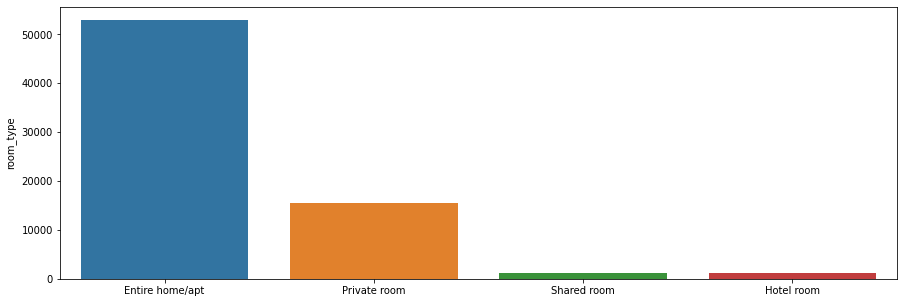

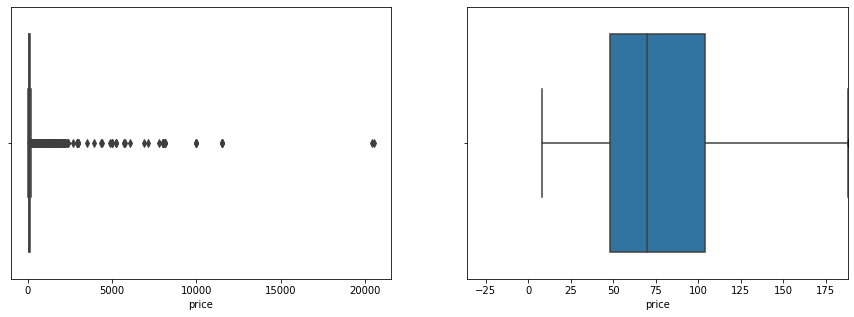

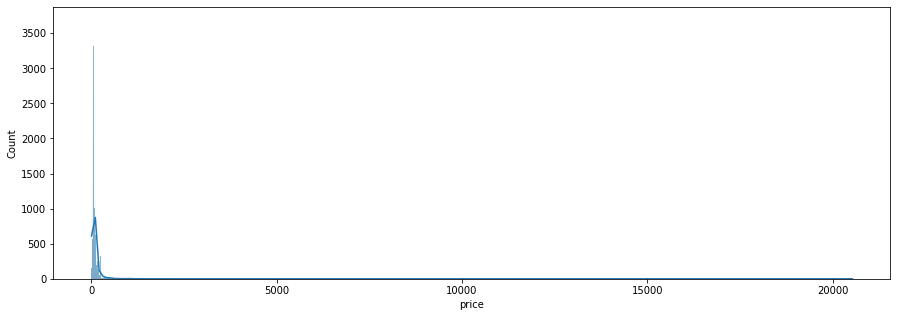

In [11]:
def outlier (col):
    q1 = col.quantile (0.25)
    q3 = col.quantile (0.75)
    iqr = q3 - q1
    lenght = 1.5
    return q1 - lenght * iqr, q3 + lenght * iqr

def box (col):
    fig, (ax1, ax2) = plt.subplots (1, 2)
    fig.set_size_inches (15, 5)
    sns.boxplot (x = col, ax = ax1)
    ax2.set_xlim (outlier (col))
    sns.boxplot (x = col, ax = ax2)

def hist (col):
    plt.figure (figsize = (15,5))
    sns.histplot (col, kde = True)

def bar (col):
    plt.figure (figsize = (15,5))
    ax = sns.barplot (x = col.value_counts ().index, y = col.value_counts ())
    if col.dtypes != "object":
        ax.set_xlim (outlier (col))
        
bar (df ["room_type"])
box (df ["price"])
hist (df ["price"])
df ["room_type"].value_counts (normalize = True)

As we can see, there is a lot of price anomalies we'd rather remove; and almost 75% of the room types consist of entire homes or apt, so we can get together private, shared and hotel rooms into just one category.

6044 rows removed
64687 total rows and 14 total columns


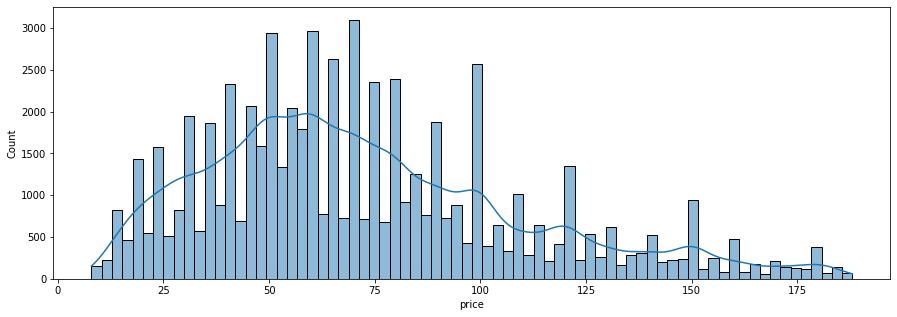

In [12]:
def remove (ds, col):
    before = ds.shape [0]
    low, up = outlier (ds [col])
    ds = ds.loc [(ds [col] >= low) & (ds [col] <= up), :]
    return ds, before - ds.shape [0]
df, removed = remove (df, "price")

aux = df ["room_type"].value_counts ()
for kind in aux.index:
    if aux [kind] < 15000:
        df.loc [df ["room_type"] == kind, "room_type"] = "Rooms"
        
print (f"{removed} rows removed")
hist (df ["price"])
print (f"{df.shape [0]} total rows and {df.shape [1]} total columns")

Almost 10% of the data were removed and I personally think that's enough discrepancies out of the equation.  
I decided that all those amenities will be counted instead of compared with each other individually.  
So why not take a look at how the dataframe appears currently and where those rentals are spread around Lisbon?

In [13]:
df ["qty"] = df ["amenities"].str.split (",").apply (len)
df ["qty"] = df ["qty"].astype (np.int32, copy = False)
display (df)
px.density_mapbox (df, lat = "latitude", lon = "longitude", z = "price", radius = 2.5, center = {"lat": df.latitude.mean (), "lon": df.longitude.mean ()}, zoom = 10, mapbox_style = "stamen-terrain").show ()

,host_is_superhost,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,number_of_reviews,instant_bookable,calculated_host_listings_count,qty
0,f,38.697498,-9.197680,Entire home/apt,3,1.0,1,1,"[""Refrigerator"", ""Dishwasher"", ""Hair dryer"", ""...",40,3,27,t,1,24
1,t,38.711670,-9.126960,Entire home/apt,2,1.0,1,1,"[""Dishes and silverware"", ""Shampoo"", ""Kitchen""...",30,10,114,t,1,27
2,f,38.712719,-9.126280,Entire home/apt,4,1.0,1,2,"[""Dishes and silverware"", ""Microwave"", ""Cookin...",43,3,325,t,1,18
4,t,38.747120,-9.152860,Entire home/apt,3,1.0,1,0,"[""Hot tub"", ""Microwave"", ""Cooking basics"", ""Ki...",48,5,41,f,1,19
5,f,38.763809,-9.152560,Rooms,6,2.0,1,3,"[""Free parking on premises"", ""Kitchen"", ""Eleva...",40,1,2,f,2,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19097,f,38.709438,-9.151200,Entire home/apt,2,1.0,1,1,"[""Fire extinguisher"", ""Room-darkening shades"",...",68,2,0,t,145,27
19099,t,38.704609,-9.202180,Entire home/apt,4,1.0,2,3,"[""Fire extinguisher"", ""Clothing storage"", ""Roo...",58,2,0,f,7,49
19101,f,38.733501,-9.142750,Rooms,2,1.0,1,1,"[""Lock on bedroom door"", ""Kitchen"", ""Long term...",31,1,0,t,3,3
19103,f,38.711952,-9.135315,Entire home/apt,3,1.0,1,0,"[""Fire extinguisher"", ""Dedicated workspace"", ""...",80,1,0,t,5,17


# 4. Encoding and Modeling  
In a new copy of the dataframe, columns with just two kinds of values will be encoded into true or false categories, since this is better when running machine learning algorithms. Later we verify the correlation among all columns and if their types are ready for modeling:

host_is_superhost                   int64
latitude                          float32
longitude                         float32
room_type                           int64
accommodates                        int32
bathrooms                         float32
bedrooms                            int32
beds                                int32
price                               int32
minimum_nights                      int32
number_of_reviews                   int32
instant_bookable                    int64
calculated_host_listings_count      int32
qty                                 int32
dtype: object

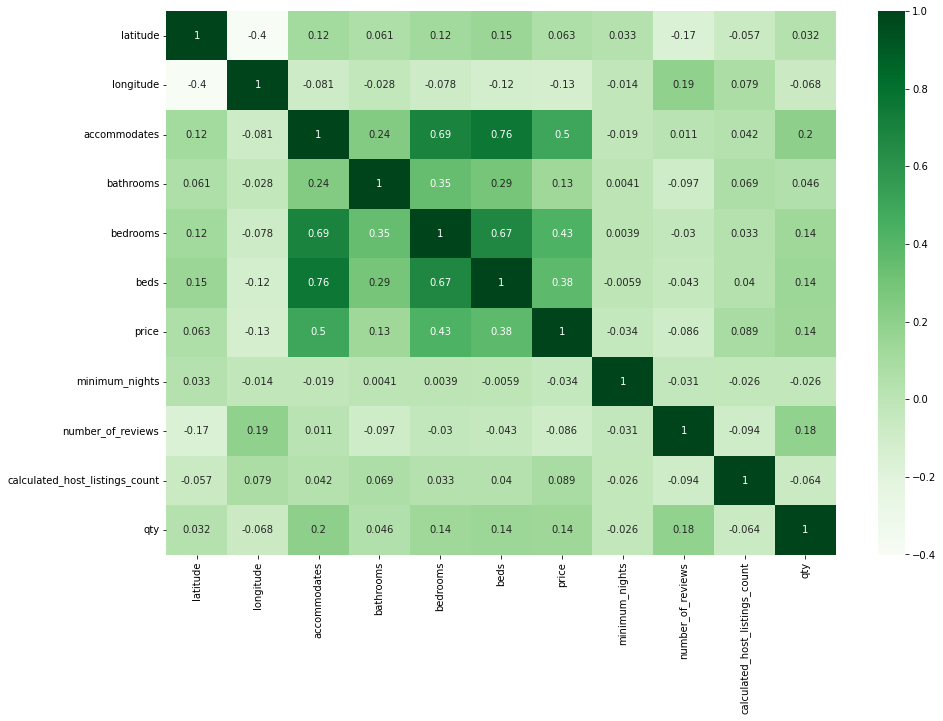

In [14]:
dfenc = df.drop ("amenities", axis = 1)
dfenc ["host_is_superhost"] = np.where (dfenc ["host_is_superhost"] == "t", 1, 0)
dfenc ["instant_bookable"] = np.where (dfenc ["instant_bookable"] == "t", 1, 0)
dfenc ["room_type"] = np.where (dfenc ["room_type"] == "Rooms", 0, 1)

plt.figure (figsize = (15,10))
sns.heatmap (df.corr (), annot = True, cmap = "Greens")
dfenc.dtypes

I am making a function that will return three evaluation methods: Root mean squared error; Mean absolute error; and R² score.  
The mean errors show by how much the model is erroring, in average. And the R² score says how much percent the model is getting it right.  
After that I'll start the regression models, split the data into 80% for training and 20% for testing, and run the models to find out the best ones.

In [15]:
def evaluate (model, ytest, prediction):
    rmse = np.sqrt (mean_squared_error (ytest, prediction))
    mae = mean_absolute_error (ytest, prediction)
    r2 = r2_score (ytest, prediction)
    return f"\n-----\nModel: {model}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\nR2: {r2:.2%}\n-----\n"

models = {'Random Forest': RandomForestRegressor (),
          'XGBRegressor': XGBRegressor (),
          'Decision Tree': DecisionTreeRegressor (),
          'Extra Trees': ExtraTreesRegressor ()
          }

y = dfenc ["price"]
x = dfenc.drop ("price", axis = 1)
xtrain, xtest, ytrain, ytest = train_test_split (x, y)

for name, model in models.items ():
    model.fit (xtrain, ytrain)
    prediction = model.predict (xtest)
    print (evaluate (name, ytest, prediction))


-----
Model: Random Forest
RMSE: 18.63
MAE: 12.52
R2: 75.09%
-----


-----
Model: XGBRegressor
RMSE: 23.44
MAE: 17.40
R2: 60.58%
-----


-----
Model: Decision Tree
RMSE: 24.87
MAE: 14.45
R2: 55.60%
-----


-----
Model: Extra Trees
RMSE: 18.79
MAE: 11.68
R2: 74.67%
-----



# 5. Comparison and Improvement  
Is it possible to improve the models, even if only their performance? We have to examine the feature importances in the best models:

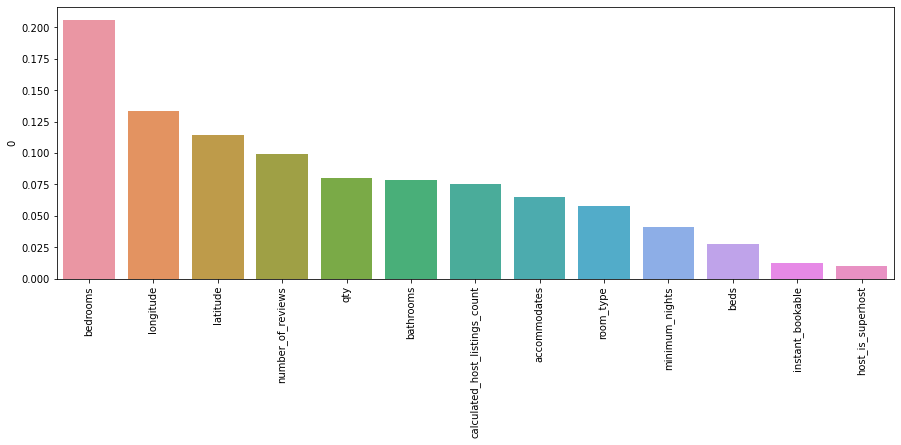

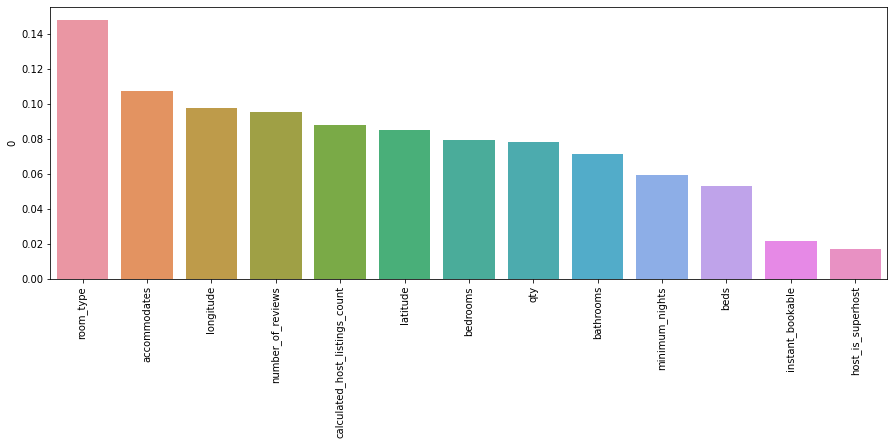

In [16]:
def important (model):
    importance = pd.DataFrame (model.feature_importances_, xtest.columns)
    importance = importance.sort_values (by = 0, ascending = False)
    plt.figure (figsize = (15, 5))
    ax = sns.barplot (x = importance.index, y = importance [0])
    ax.tick_params (axis = "x", rotation = 90)

important (models ["Random Forest"])
important (models ["Extra Trees"])

In both of them the least important features are the same, so I'm going to drop them and rerun just these models to observe if there will be any improvement, or if it, at least, stays the same with the advantage of being simpler, due to needing fewer columns:

In [17]:
dfenc = dfenc.drop ("host_is_superhost", axis = 1)
dfenc = dfenc.drop ("instant_bookable", axis = 1)

y = dfenc ["price"]
x = dfenc.drop ("price", axis = 1)
xtrain, xtest, ytrain, ytest = train_test_split (x, y)

for name, model in models.items ():
    if name == 'Random Forest' or name == 'Extra Trees':
        model.fit (xtrain, ytrain)
        prediction = model.predict (xtest)
        print (evaluate (name, ytest, prediction))


-----
Model: Random Forest
RMSE: 18.51
MAE: 12.42
R2: 75.45%
-----


-----
Model: Extra Trees
RMSE: 18.48
MAE: 11.30
R2: 75.52%
-----



# 6. Conclusion  
Both models have improved, with Extra Trees being slightly better by providing circa 75% success rate and less than only 20 of average errors.  
I hope this proofs helpful for anyone trying to price Airbnb rentals right in Lisbon, Portugal.